In [1]:
#!unzip animal+utils.zip
#!pip install utils
#!unzip nature.zip
#from google.colab import drive
#drive.mount('/content/drive')
#from google.colab import files
#src=list(files.upload().values())[0]
#open('utils.py','wb').write(src)
import utils

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
#import utils

In [3]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=1024
dropratio=0.5

Imgsize=256

In [4]:
Img_dir="drive/MyDrive/Colab Notebooks/nature/train"
train_data= dset.ImageFolder(Img_dir, transforms.Compose([
    transforms.CenterCrop(Imgsize*2),
    transforms.RandomCrop(Imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch=data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)

45


In [5]:
img_dir="drive/MyDrive/Colab Notebooks/nature/val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=Imgsize),
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
dev_batch=data.DataLoader(dev_data,batch_size=batch_size,shuffle=True,num_workers=2)
img_dir="drive/MyDrive/Colab Notebooks/nature/test"
test_data=dset.ImageFolder(img_dir,transforms.Compose([
    transforms.CenterCrop(size=Imgsize),
    transforms.Resize(Imgsize),
    transforms.ToTensor()
]))
test_batch=data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=2)
nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())
print("Training: %d, Dev: %d, Test:%d" %(train_data.__len__(),dev_data.__len__(),test_data.__len__())),

# of classes: 2
['mountain', 'ocean']
{'mountain': 0, 'ocean': 1}
45
Training: 45, Dev: 18, Test:35


(None,)

In [6]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['mountain', 'ocean']
['mountain', 'ocean']
['mountain', 'ocean']


In [7]:
vgg=models.vgg19(pretrained=True)
for name,module in vgg.named_children():
    print(name)
print(list(vgg.children())[0])
print(list(vgg.children())[-1])
print(list(vgg.children())[0][0])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [8]:
base_dim=64
fsize=int(Imgsize/32)

class MYVGG(nn.Module):
    def __init__(self):
        super(MYVGG,self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        self.layer1=nn.Sequential(
          nn.Linear(8*base_dim*int(fsize)*int(fsize),n_node),
          nn.BatchNorm1d(n_node),
          nn.ReLU(),
          nn.Dropout2d(dropratio),
          
          nn.Linear(n_node,n_node),
          nn.BatchNorm1d(n_node),
          nn.ReLU(),
          nn.Dropout2d(dropratio),
          
          nn.Linear(n_node,n_node),
          nn.BatchNorm1d(n_node),
          nn.ReLU(),
          nn.Dropout2d(dropratio),
          
          nn.Linear(n_node,nclass),
        )
        for m in self.layer1.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self,x):
        out=self.layer0(x)
        out=out.view(out.size(0),-1)
        out=self.layer1(out)
        return out

In [9]:
model=MYVGG().cuda()
for params in model.layer0.parameters():
    params.required_grad=False
for params in model.layer1.parameters():
    params.required_grad=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [10]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(),lr=learning_rate)

In [12]:
import utils

total_time = 0
disp_step = 10

to_train = True #switch

if (to_train == False):# 미리 학습 된 모델 불러오기
    # 구조 정보와 세타 정보 포함
    netname = 'drive/MyDrive/Colab Notebooks/nets/TigerLion_vgg19_10.pkl'
    model = torch.load(netname)
    
else : # train한다.
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = 'drive/MyDrive/Colab Notebooks/nets/TigerLion_vgg19_10.pkl'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    # 10번 epoch 돌 때 마다 에러율 저장
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면
    # netname = 'drive/MyDrive/Colab Notebooks/nets/TigerLion_vgg19_10.pkl'
    # model = torch.load(netname)
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
    #    params.required_grad = False
    # for params in model.layer1.parameters():
    #    params.required_grad = True
    # for i in range(34,epoch):

    # 재시작하지 않는다면, 재시작 할 때는 주석
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step ==0) or (i == epoch -1): # 네트워크 데이터(세타) 백업
            torch.save(model, netname+'_%d.pkl'%i, ) # 중간에 저장한다
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            # 학습이 잘 되고 있는지 모니터링
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node : 1024, dropratio: 0.50
Correct of train: 51.11, dev: 51.11, test: 51.11
0..

[0/20] loss: 0.578,
Correct of train: 48.89, dev: 50.00, test: 50.00
time: 1.87 sec...
Total time: 1.87 sec
1..
Total time: 3.87 sec
2..
Total time: 5.85 sec
3..
Total time: 7.84 sec
4..
Total time: 9.82 sec
5..
Total time: 11.82 sec
6..
Total time: 13.81 sec
7..
Total time: 15.79 sec
8..
Total time: 17.78 sec
9..
Total time: 19.77 sec
10..

[10/20] loss: 0.368,
Correct of train: 88.89, dev: 72.22, test: 72.22
time: 21.75 sec...
Total time: 21.75 sec
11..
Total time: 23.62 sec
12..
Total time: 25.60 sec
13..
Total time: 27.59 sec
14..
Total time: 29.63 sec
15..
Total time: 31.57 sec
16..
Total time: 33.56 sec
17..
Total time: 35.55 sec
18..
Total time: 37.54 sec
19..

[19/20] loss: 0.351,
Correct of train: 95.56, dev: 72.22, test: 72.22
time: 39.52 sec...
Total time: 39.52 sec


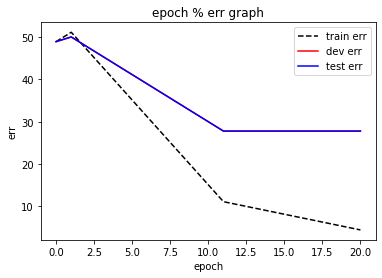

In [14]:
if(to_train):
    plt.plot(x_epoch,y_train_err,color='black',label='train err',linestyle='--')
    plt.plot(x_epoch,y_dev_err,color='red',label='dev err')
    plt.plot(x_epoch,y_test_err,color='blue',label='test err')
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch % err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


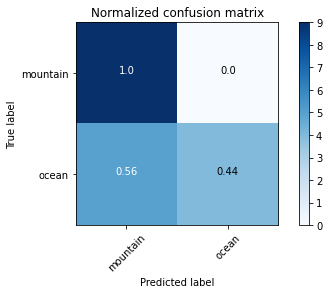

Confusion matrix, without normalization


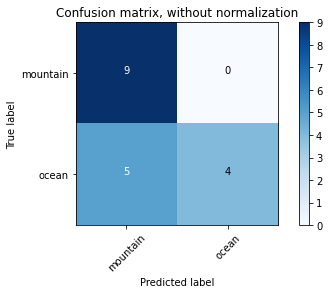

	 acc  |	 pre  |	 rec  |	 f1
 mountain: 0.72 |	 0.64 |	 1.00 |	 0.78
 ocean: 0.72 |	 1.00 |	 0.44 |	 0.62
*accuracy: 0.72, precision: 0.82, recall: 0.72, *f1 score: 0.70
[AP]
mountain: 0.98
ocean: 0.98

[mAP] 0.978
[miAP] 0.861


(array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]),
 array([0.97593963, 0.85601157, 0.56891149, 0.98015755, 0.87023759,
        0.91089159, 0.87580645, 0.94961631, 0.95059717, 0.64093351,
        0.98356718, 0.83828473, 0.68863153, 0.99323332, 0.9308309 ,
        0.71798414, 0.98941165, 0.81545866]))

In [16]:
model.eval()
utils.EvaluateClassifier(dev_batch,model,dev_data.classes, batch_size)

Normalized confusion matrix


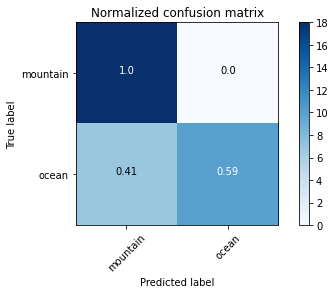

Confusion matrix, without normalization


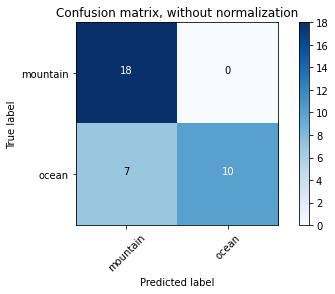

	 acc  |	 pre  |	 rec  |	 f1
 mountain: 0.80 |	 0.72 |	 1.00 |	 0.84
 ocean: 0.80 |	 1.00 |	 0.59 |	 0.74
*accuracy: 0.80, precision: 0.86, recall: 0.79, *f1 score: 0.79
[AP]
mountain: 0.99
ocean: 0.99

[mAP] 0.991
[miAP] 0.900


In [17]:
model.eval()
_,_,_= utils.EvaluateClassifier(test_batch,model,test_data.classes,batch_size)

Category: mountain
 True predicted images/total mountain category: 9 / 9
Predicted probability:
[0.98015755 0.01984245]


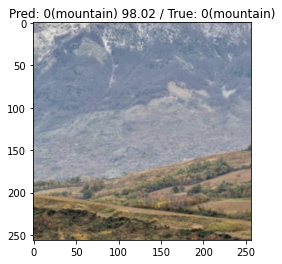

Predicted probability:
[0.87580645 0.12419354]


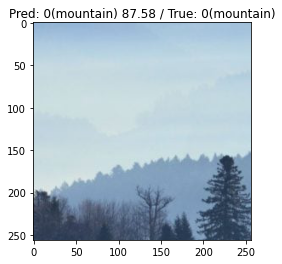

 False predicted images/total mountain category: 0 / 9
Category: ocean
 True predicted images/total ocean category: 4 / 9
Predicted probability:
[0.12976243 0.8702376 ]


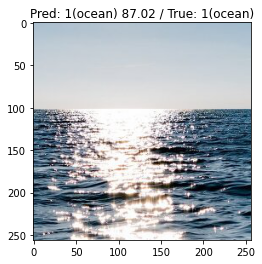

Predicted probability:
[0.4310885 0.5689115]


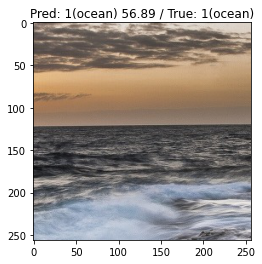

 False predicted images/total ocean category: 5 / 9
Predicted probability:
[0.8154588  0.18454126]


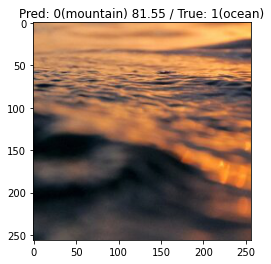

Predicted probability:
[0.9308309  0.06916908]


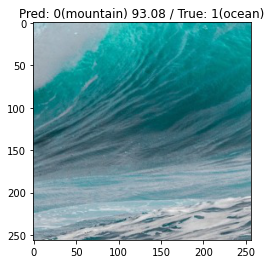

In [18]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)

Category: mountain
 True predicted images/total mountain category: 9 / 9
Predicted probability:
[0.9835672  0.01643284]


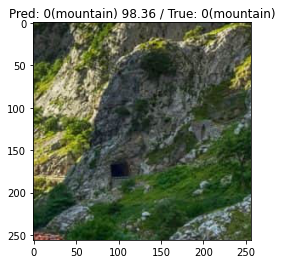

Predicted probability:
[0.98941165 0.01058837]


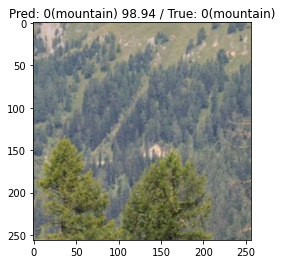

 False predicted images/total mountain category: 0 / 9
Category: ocean
 True predicted images/total ocean category: 4 / 9
Predicted probability:
[0.3590665 0.6409335]


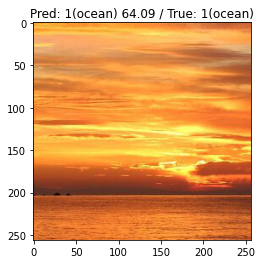

Predicted probability:
[0.28201583 0.71798414]


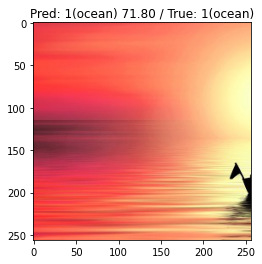

 False predicted images/total ocean category: 5 / 9
Predicted probability:
[0.83828473 0.16171528]


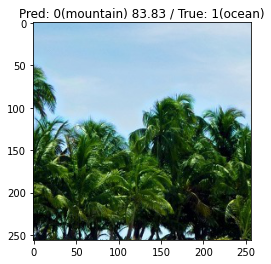

Predicted probability:
[0.68863153 0.31136844]


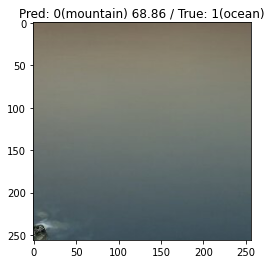

In [19]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)

Category: mountain
 True predicted images/total mountain category: 9 / 9
Predicted probability:
[0.87580645 0.12419354]


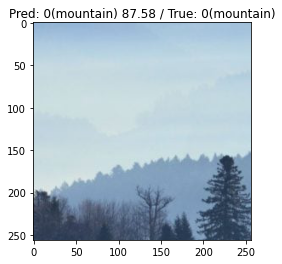

Predicted probability:
[0.9835672  0.01643284]


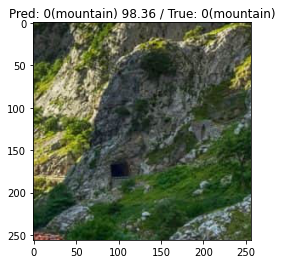

 False predicted images/total mountain category: 0 / 9
Category: ocean
 True predicted images/total ocean category: 4 / 9
Predicted probability:
[0.28201583 0.71798414]


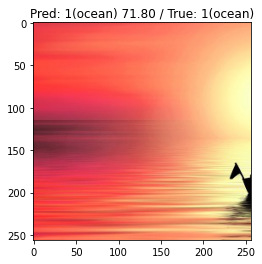

Predicted probability:
[0.12976243 0.8702376 ]


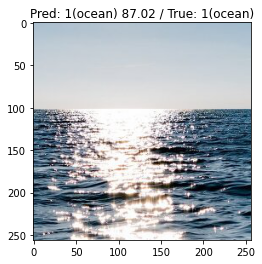

 False predicted images/total ocean category: 5 / 9
Predicted probability:
[0.68863153 0.31136844]


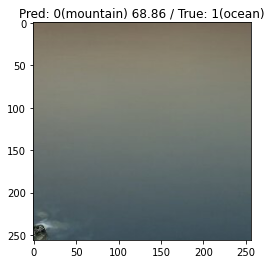

Predicted probability:
[0.9308309  0.06916908]


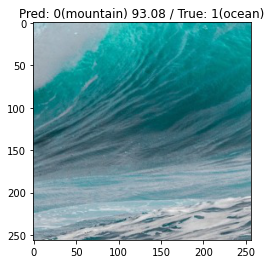

In [20]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)